## Task 1: Load the KDD99Cup data and prepare to train DOS vs non-DOS
We have downloaded the the KDD99Cup data and have it in the local directory as "kddcup.data". We have also created a file called "kddcup.headers" in the local directory, which is a space delimited list of the header names for the features. We load the data into a DataFrame. We create a target array which is 1 for DOS attacks and 0 for all other records.

Since SVM is very computationally expensive, we reduce our data set to 100,000 DOS records and 100,000 non-DOS records. We then use OneHotEncoder to encode the categorical columns, and finally scale our columns using MinMaxScaler.

In [1]:
# Load kddcup data. This was downloaded and placed in the same directory as the notebook.
# For header names, use file we created in the local directory called "kddcup.headers".
import pandas as pd
import numpy as np
import timeit

df = pd.read_csv('kddcup.data')
headers = np.genfromtxt('kddcup.headers', dtype=str, delimiter=" ")

In [2]:
# Print the shape of the original data set, for reference
print(f"shape of data set: {df.shape}")

# Set the feature set (X) to columns 0-40 of the data set. Set the headers of the feature set using the
# file we imported above.
X = df.iloc[:, 0:41]
X.columns = headers
print(f"shape of X: {X.shape}")

# Create an ndarray "y_raw" with the target labels from column 41 of the data set. Call it "y_raw" as we
# will encode it to create our target array y.
y_raw = df.iloc[:, 41].values
print(f"shape of y_raw: {y_raw.shape}")
print()

#Print the number of records of each class
from collections import Counter
class_counts = Counter(y_raw)
print("Count of records of each type:")
for c in class_counts:
    print(f"{c}: {class_counts[c]}")

shape of data set: (4898430, 42)
shape of X: (4898430, 41)
shape of y_raw: (4898430,)

Count of records of each type:
normal.: 972780
buffer_overflow.: 30
loadmodule.: 9
perl.: 3
neptune.: 1072017
smurf.: 2807886
guess_passwd.: 53
pod.: 264
teardrop.: 979
portsweep.: 10413
ipsweep.: 12481
land.: 21
ftp_write.: 8
back.: 2203
imap.: 12
satan.: 15892
phf.: 4
nmap.: 2316
multihop.: 7
warezmaster.: 20
warezclient.: 1020
spy.: 2
rootkit.: 10


In [3]:
# Look at the occurence of the different categories in the categorical features
print(Counter(X['protocol_type']))
print(Counter(X['service']))
print(Counter(X['flag']))

Counter({'icmp': 2833545, 'tcp': 1870597, 'udp': 194288})
Counter({'ecr_i': 2811660, 'private': 1100831, 'http': 623090, 'smtp': 96554, 'other': 72653, 'domain_u': 57782, 'ftp_data': 40697, 'eco_i': 16338, 'finger': 6891, 'urp_i': 5378, 'ftp': 5214, 'telnet': 4277, 'ntp_u': 3833, 'auth': 3382, 'pop_3': 1981, 'time': 1579, 'domain': 1113, 'Z39_50': 1078, 'gopher': 1077, 'mtp': 1076, 'ssh': 1075, 'whois': 1073, 'remote_job': 1073, 'rje': 1070, 'link': 1069, 'imap4': 1069, 'ctf': 1068, 'name': 1067, 'supdup': 1060, 'echo': 1059, 'discard': 1059, 'nntp': 1059, 'uucp_path': 1057, 'netstat': 1056, 'daytime': 1056, 'systat': 1056, 'sunrpc': 1056, 'netbios_ssn': 1055, 'pop_2': 1055, 'netbios_ns': 1054, 'vmnet': 1053, 'netbios_dgm': 1052, 'sql_net': 1052, 'iso_tsap': 1052, 'shell': 1051, 'csnet_ns': 1051, 'klogin': 1050, 'hostnames': 1050, 'bgp': 1047, 'login': 1045, 'exec': 1045, 'printer': 1045, 'http_443': 1044, 'efs': 1042, 'uucp': 1041, 'ldap': 1041, 'kshell': 1040, 'nnsp': 1038, 'courier'

In [4]:
# Define a function for converting target labels to 1 (DOS) or 0 (non-DOS). We will use this function
# to encode the target array.
dosAttackTypes = ["back.", "land.", "neptune.", "pod.", "smurf.", "teardrop."]

def DOSEncode(x):
    if (x in dosAttackTypes):
        return 1
    else:
        return 0

In [5]:
# Use the Dataframe function "applymap" to apply our encoding function "DOSEncode" to convert the target
# labels into 1's and 0's.
labels=pd.DataFrame(data=y_raw)
labels2 = labels.applymap(DOSEncode)
y = labels2[0].values

# Print out the counts of the encoded values.
print(Counter(y))

Counter({1: 3883370, 0: 1015060})


In [6]:
# The dataset is unbalanced, we have many more failure cases than success cases. Use RandomUnderSampler to 
# balance the number of records of each type.
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

# Print the shape of the original data set
print('Original dataset shape %s' % Counter(y))

# Use RandomUnderSampler, to take 100,000 DOS records and 100,000 non-DOS records
# Had to limit to only that number of samples, or else SVM was not converging in a reasonable amount of time
rus = RandomUnderSampler(random_state=0, sampling_strategy={1:100000, 0:100000})
X1, y1 = rus.fit_resample(X, y)

# Print shape of resampled data set, and count of label values in the target array
print(f'Resampled dataset shape: {X1.shape}')
print(f'Count of label values: {Counter(y1)}')

Original dataset shape Counter({1: 3883370, 0: 1015060})
Resampled dataset shape: (200000, 41)
Count of label values: Counter({0: 100000, 1: 100000})


In [7]:
# Use OneHotEncoder on protocol_type
from sklearn.preprocessing import OneHotEncoder

# Create a dataframe of encoded data from "protocol_type"
enc = OneHotEncoder(sparse=False)
X2 = pd.DataFrame(enc.fit_transform(X1[['protocol_type']]))
X2.columns = enc.get_feature_names_out(['protocol_type'])

# Drop the original "protocol_type" column, and merge in the new encoded columns
X3 = X1.copy()
X3.drop(['protocol_type'], axis=1, inplace=True)
X4 = pd.concat([X3, X2], axis=1)

# Print the resultant shape
print(X4.shape)

(200000, 43)


In [8]:
# Use OneHotEncoder on service

# Create a dataframe of encoded data from "service"
X5 = pd.DataFrame(enc.fit_transform(X4[['service']]))
X5.columns = enc.get_feature_names_out(['service'])

# Drop the original "service" column, and merge in the new encoded columns
X6 = X4.copy()
X6.drop(['service'], axis=1, inplace=True)
X7 = pd.concat([X6, X5 ], axis=1)

# Print the resultant shape
print(X7.shape)

(200000, 106)


In [9]:
# Use OneHotEncoder on flag

# Create a dataframe of encoded data from "flag"
X8 = pd.DataFrame(enc.fit_transform(X7[['flag']]))
X8.columns = enc.get_feature_names_out(['flag'])

# Drop the original "flag" column, and merge in the new encoded columns
X9 = X7.copy()
X9.drop(['flag'], axis=1, inplace=True)
X10 = pd.concat([X9, X8], axis=1)

# Print the resultant shape
print(X10.shape)

(200000, 116)


In [10]:
# Store final feature set into X_encoded
X_encoded = X10

# View dataframe
X_encoded

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,253,2174,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1564,673,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,349,22780,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,311,1310,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,215,955,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
199996,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
199997,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
199998,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Standardize the feature set data to help with training.
from sklearn import preprocessing

# Use MinMaxScaler to scale the data set
scaler = preprocessing.MinMaxScaler().fit(X_encoded)
scaledArray = scaler.transform(X_encoded)
X_scaled = pd.DataFrame(data=scaledArray, columns=X_encoded.columns)

# View dataframe
X_scaled.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.002755,1.018007e-05,0.000315,0.000010,0.000095,0.000008,0.000908,0.000014,0.346605,0.000024,...,0.059415,0.000925,0.000045,0.004215,0.11339,0.00024,0.000105,0.000020,0.821030,0.000575
std,0.027209,2.248607e-03,0.005186,0.003162,0.009574,0.002472,0.023290,0.002757,0.475890,0.003911,...,0.236400,0.030400,0.006708,0.064786,0.31707,0.01549,0.010246,0.004472,0.383328,0.023972
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.832533e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.394531e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,4.749690e-06,0.000075,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


### Dimensionality reduction

We were not able to get the SVM kernels to run in a reasonable time. Therefore with permission from the professor, we are identifying 15 of the most important features and limiting our data set to those features.

We select the features using sklearn's SelectKBest class. Once we have selected our features, we drop the others from our data set.

In [12]:
# Select the 15 best features via SelectKBest, and then store their names into the array "features_to_keep"
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

print("selecting 15 best features to use:")
selector = SelectKBest(chi2, k=15).fit(X_scaled, y1)
features_to_keep = selector.get_feature_names_out()
print(features_to_keep)

selecting 15 best features to use:
['logged_in' 'count' 'srv_count' 'serror_rate' 'srv_serror_rate'
 'srv_diff_host_rate' 'dst_host_same_src_port_rate' 'dst_host_serror_rate'
 'dst_host_srv_serror_rate' 'protocol_type_icmp' 'protocol_type_tcp'
 'protocol_type_udp' 'service_ecr_i' 'service_http' 'flag_S0']


In [13]:
# Create a new Dataframe "X_reduced", which starts as a copy of our final data set from above.
# Loop through "X_reduced", and drop every column which is not part of the array "features_to_keep".
columnList = X_scaled.columns

X_reduced = X_scaled.copy()
for column in columnList:
    if (column not in features_to_keep):
        X_reduced.drop(columns=column, inplace=True)

X_reduced

,logged_in,count,srv_count,serror_rate,srv_serror_rate,srv_diff_host_rate,dst_host_same_src_port_rate,dst_host_serror_rate,dst_host_srv_serror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_ecr_i,service_http,flag_S0
0,1.0,0.001957,0.001957,0.0,0.0,0.00,1.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.003914,0.003914,0.0,0.0,1.00,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.023483,0.054795,0.0,0.0,0.07,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.007828,0.007828,0.0,0.0,0.00,0.03,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.031311,0.031311,0.0,0.0,0.00,0.01,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,0.577299,0.023483,1.0,1.0,0.00,0.00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
199996,0.0,0.506849,0.011742,1.0,1.0,0.00,0.00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
199997,0.0,1.000000,1.000000,0.0,0.0,0.00,1.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
199998,0.0,1.000000,1.000000,0.0,0.0,0.00,1.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Split data into Test and Train data sets

In [14]:
# Split the data into a training set (80%) and testing set (20%).
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y1, test_size=0.2, random_state=0)
print(f"training set shape: {X_train.shape}")
print(f"testing set shape: {X_test.shape}")

training set shape: (160000, 15)
testing set shape: (40000, 15)


## Task 2: Run the SVM Model with 4 Different Kernels, and compare the results

### Train and test with "rbf" kernel

In [15]:
# Create RBF classifier and train with the training set.
from sklearn.svm import SVC
import time

svm1 = SVC(kernel='rbf', random_state=0)
print(svm1.get_params())

# Time how long it takes to train.
start = time.time()
svm1.fit(X_train, y_train)
end = time.time()
svm1_train_time = end - start

print(f"secs to fit: {svm1_train_time:.2f}")
print(f"iterations required: {svm1.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
secs to fit: 3.66
iterations required: [1061]


In [16]:
# Predict the training set. Time how long it takes to predict.
start = time.time()
svm1_train_predict = svm1.predict(X_train)
end = time.time()
svm1_pred_time = end - start

print(f"secs to predict (training set): {svm1_pred_time:.2f}")

secs to predict (training set): 6.63


              precision    recall  f1-score   support

      nondos     0.9990    0.9990    0.9990     80087
         dos     0.9990    0.9990    0.9990     79913

    accuracy                         0.9990    160000
   macro avg     0.9990    0.9990    0.9990    160000
weighted avg     0.9990    0.9990    0.9990    160000



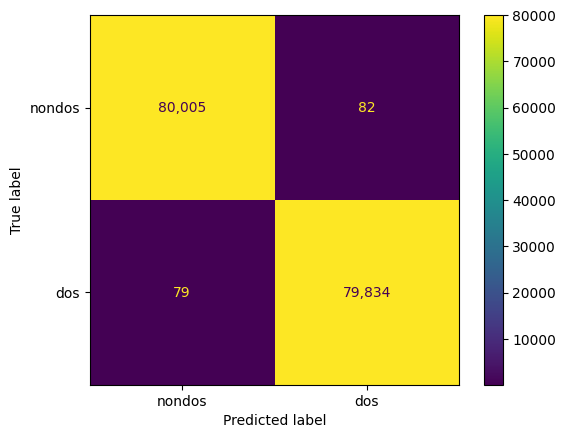

In [17]:
# Print classification report and ConfusionMatrix for training data set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_train, svm1_train_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_train, svm1_train_predict, values_format=",", display_labels = target_names)
plt.show()

In [18]:
# Predict the test set. Time how long it takes to predict.
start = time.time()
svm1_test_predict = svm1.predict(X_test)
end = time.time()
svm1_test_time = end - start

print(f"secs to predict (test set): {svm1_test_time:.2f}")

secs to predict (test set): 1.65


              precision    recall  f1-score   support

      nondos     0.9992    0.9987    0.9990     19913
         dos     0.9987    0.9993    0.9990     20087

    accuracy                         0.9990     40000
   macro avg     0.9990    0.9990    0.9990     40000
weighted avg     0.9990    0.9990    0.9990     40000



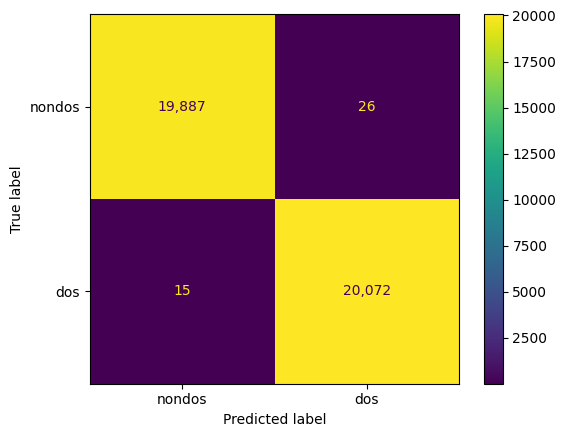

In [19]:
# Print classification report and ConfusionMatrix for test data set
from sklearn.metrics import classification_report

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_test, svm1_test_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, svm1_test_predict, values_format=",", display_labels = target_names)
plt.show()

### Train and test with "linear" kernel

In [20]:
# Create Linear classifier and train with the training set.
from sklearn.svm import SVC
import time

svm2 = SVC(kernel='linear', random_state=0)
print(svm2.get_params())

# Time how long it takes to train.
start = time.time()
svm2.fit(X_train, y_train)
end = time.time()
svm2_train_time = end - start

print(f"secs to fit: {svm2_train_time:.2f}")
print(f"iterations required: {svm2.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
secs to fit: 11.85
iterations required: [5943]


In [21]:
# Predict the training set. Time how long it takes to predict.
start = time.time()
svm2_train_predict = svm2.predict(X_train)
end = time.time()
svm2_pred_time = end - start

print(f"secs to predict (training set): {svm2_pred_time:.2f}")

secs to predict (training set): 5.69


              precision    recall  f1-score   support

      nondos     0.9986    0.9904    0.9945     80087
         dos     0.9904    0.9986    0.9945     79913

    accuracy                         0.9945    160000
   macro avg     0.9945    0.9945    0.9945    160000
weighted avg     0.9945    0.9945    0.9945    160000



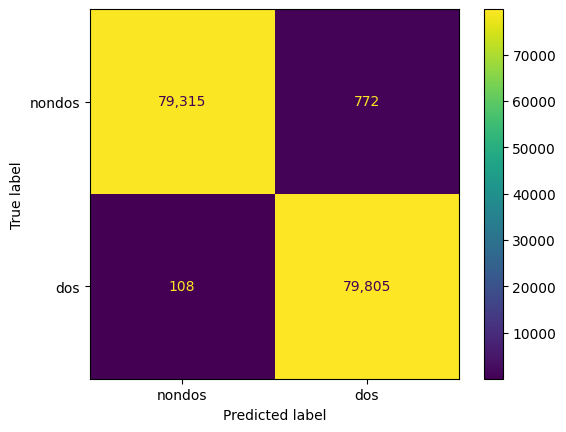

In [22]:
# Print classification report and ConfusionMatrix for training data set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_train, svm2_train_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_train, svm2_train_predict, values_format=",", display_labels = target_names)
plt.show()

In [23]:
# Predict the test set. Time how long it takes to predict.
start = time.time()
svm2_test_predict = svm2.predict(X_test)
end = time.time()
svm2_test_time = end - start

print(f"secs to predict (test set): {svm2_test_time:.2f}")

secs to predict (test set): 1.44


              precision    recall  f1-score   support

      nondos     0.9989    0.9909    0.9949     19913
         dos     0.9910    0.9989    0.9949     20087

    accuracy                         0.9949     40000
   macro avg     0.9949    0.9949    0.9949     40000
weighted avg     0.9949    0.9949    0.9949     40000



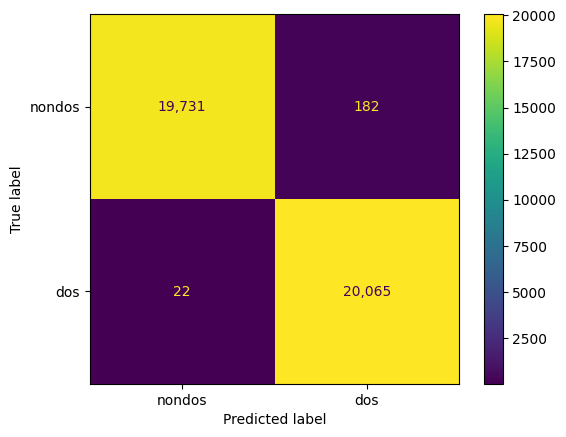

In [24]:
# Print classification report and ConfusionMatrix for test data set
from sklearn.metrics import classification_report

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_test, svm2_test_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, svm2_test_predict, values_format=",", display_labels = target_names)
plt.show()

### Train and test with "poly" kernel

In [25]:
# Create Poly classifier and train with the training set.
from sklearn.svm import SVC
import time

svm3 = SVC(kernel='poly', random_state=0)
print(svm3.get_params())

# Time how long it takes to train.
start = time.time()
svm3.fit(X_train, y_train)
end = time.time()
svm3_train_time = end - start

print(f"secs to fit: {svm3_train_time:.2f}")
print(f"iterations required: {svm3.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
secs to fit: 107.14
iterations required: [1821]


In [26]:
# Predict the training set. Time how long it takes to predict.
start = time.time()
svm3_train_predict = svm3.predict(X_train)
end = time.time()
svm3_pred_time = end - start

print(f"secs to predict (training set): {svm3_pred_time:.2f}")

secs to predict (training set): 3.08


              precision    recall  f1-score   support

      nondos     0.9990    0.9989    0.9990     80087
         dos     0.9989    0.9990    0.9990     79913

    accuracy                         0.9990    160000
   macro avg     0.9990    0.9990    0.9990    160000
weighted avg     0.9990    0.9990    0.9990    160000



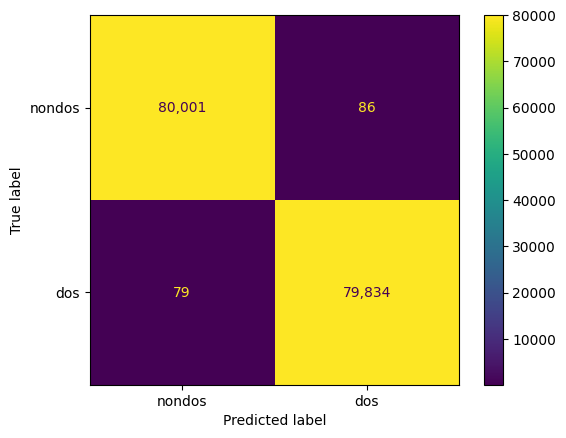

In [27]:
# Print classification report and ConfusionMatrix for training data set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_train, svm3_train_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_train, svm3_train_predict, values_format=",", display_labels = target_names)
plt.show()

In [28]:
# Predict the test set. Time how long it takes to predict.
start = time.time()
svm3_test_predict = svm3.predict(X_test)
end = time.time()
svm3_test_time = end - start

print(f"secs to predict (test set): {svm3_test_time:.2f}")

secs to predict (test set): 0.79


              precision    recall  f1-score   support

      nondos     0.9992    0.9987    0.9990     19913
         dos     0.9987    0.9993    0.9990     20087

    accuracy                         0.9990     40000
   macro avg     0.9990    0.9990    0.9990     40000
weighted avg     0.9990    0.9990    0.9990     40000



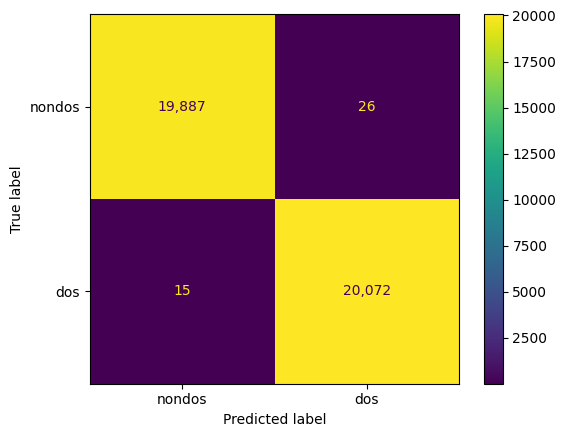

In [29]:
# Print classification report and ConfusionMatrix for test data set
from sklearn.metrics import classification_report

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_test, svm3_test_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, svm3_test_predict, values_format=",", display_labels = target_names)
plt.show()

### Train and test with "sigmoid" kernel

In [30]:
# Create Poly classifier and train with the training set.
from sklearn.svm import SVC
import time

svm4 = SVC(kernel='sigmoid', random_state=0)
print(svm4.get_params())

# Time how long it takes to train.
start = time.time()
svm4.fit(X_train, y_train)
end = time.time()
svm4_train_time = end - start

print(f"secs to fit: {svm4_train_time:.2f}")
print(f"iterations required: {svm4.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
secs to fit: 335.51
iterations required: [8182]


In [31]:
# Predict the training set. Time how long it takes to predict.
start = time.time()
svm4_train_predict = svm4.predict(X_train)
end = time.time()
svm4_pred_time = end - start

print(f"secs to predict (training set): {svm4_pred_time:.2f}")

secs to predict (training set): 18.25


              precision    recall  f1-score   support

      nondos     0.9764    0.9687    0.9725     80087
         dos     0.9689    0.9765    0.9727     79913

    accuracy                         0.9726    160000
   macro avg     0.9726    0.9726    0.9726    160000
weighted avg     0.9726    0.9726    0.9726    160000



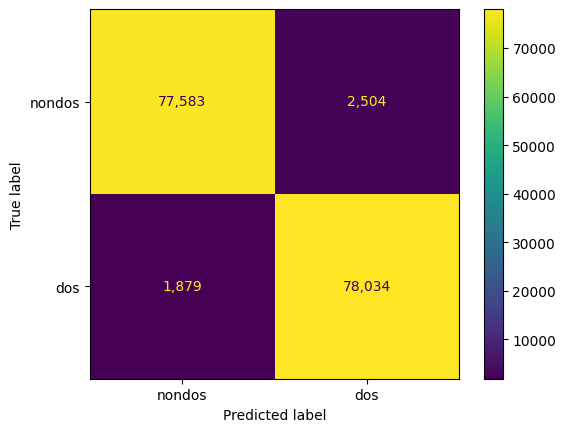

In [32]:
# Print classification report and ConfusionMatrix for training data set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_train, svm4_train_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_train, svm4_train_predict, values_format=",", display_labels = target_names)
plt.show()

In [33]:
# Predict the test set. Time how long it takes to predict.
start = time.time()
svm4_test_predict = svm4.predict(X_test)
end = time.time()
svm4_test_time = end - start

print(f"secs to predict (test set): {svm4_test_time:.2f}")

secs to predict (test set): 4.61


              precision    recall  f1-score   support

      nondos     0.9753    0.9669    0.9711     19913
         dos     0.9675    0.9758    0.9716     20087

    accuracy                         0.9714     40000
   macro avg     0.9714    0.9713    0.9713     40000
weighted avg     0.9714    0.9714    0.9713     40000



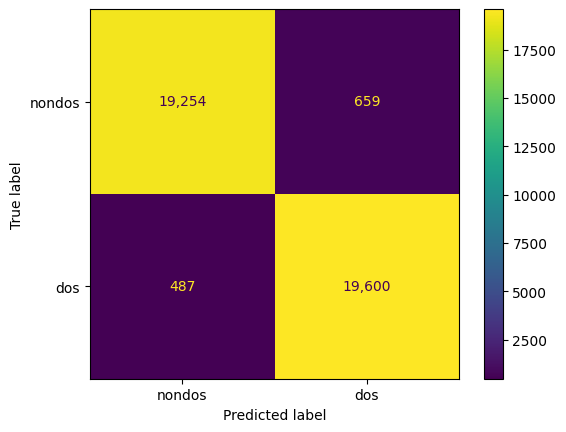

In [34]:
# Print classification report and ConfusionMatrix for test data set
from sklearn.metrics import classification_report

target_labels = [0, 1]
target_names = ['nondos', 'dos']
print(classification_report(y_test, svm4_test_predict, labels=target_labels, target_names=target_names, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, svm4_test_predict, values_format=",", display_labels = target_names)
plt.show()

### Compare Kernels

Below we compare the results of the different kernels. We see that Poly and RBF had the best accuracy, with linear slightly lower and sigmoid much lower. Sigmoid and Poly took much more time to train than the other two; linear required a lot of iterations to train, but the time needed was not as much as Sigmoid or Poly. Surprisingly, though Poly took a long time to train, it has the fastest testing time of any of the kernels.

Overall, RBF gives the best results for this data set, both in computation requirements to train and in accuracy results.

In [35]:
# Generate scores array for all the different SVM kernels
scores = []
scores.append(svm1.score(X_test, y_test))
scores.append(svm2.score(X_test, y_test))
scores.append(svm3.score(X_test, y_test))
scores.append(svm4.score(X_test, y_test))

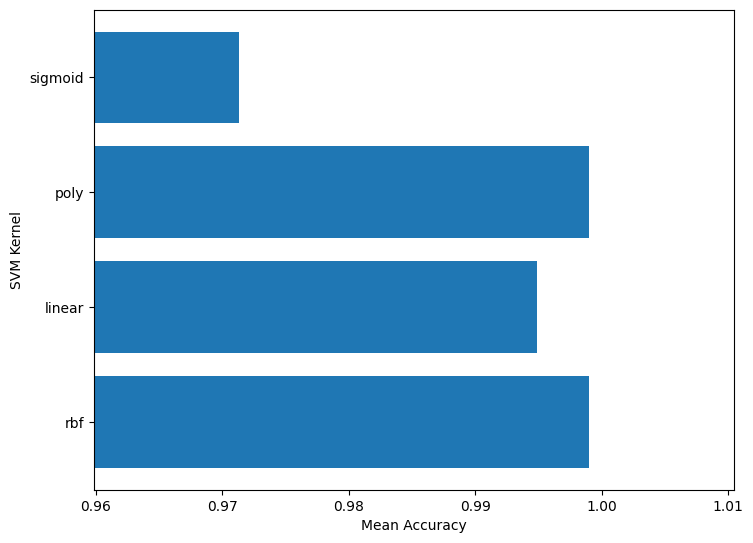

In [36]:
# Plot the scores (mean accuracy) for each SVM kernel type
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
ax.barh(kernels,scores)

max_xlim = max(scores) + np.std(scores)
min_xlim = min(scores) - np.std(scores)
plt.xlim(min_xlim, max_xlim)
plt.xlabel('Mean Accuracy')
plt.ylabel('SVM Kernel')
plt.show()

In [37]:
# Generate train_times array
train_times = []
train_times.append(svm1_train_time)
train_times.append(svm2_train_time)
train_times.append(svm3_train_time)
train_times.append(svm4_train_time)

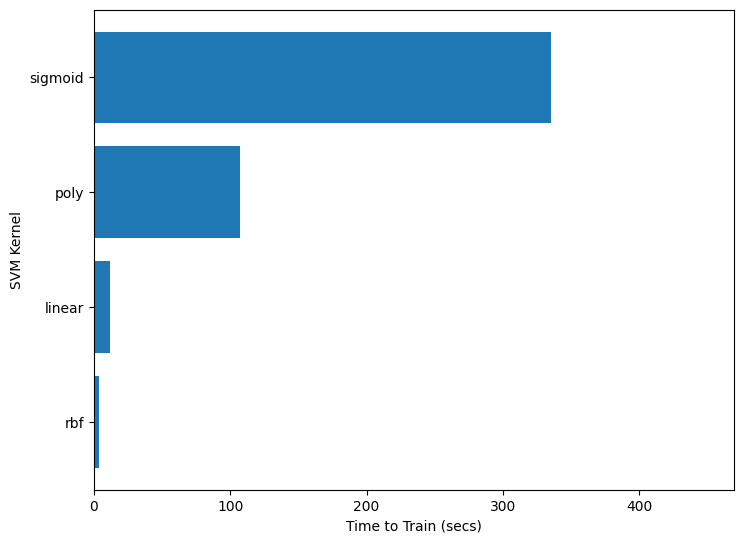

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
ax.barh(kernels,train_times)

max_xlim = max(train_times) + np.std(train_times)
min_xlim = 0
plt.xlim(min_xlim, max_xlim)
plt.xlabel('Time to Train (secs)')
plt.ylabel('SVM Kernel')
plt.show()

In [39]:
# Generate number of iterations array
num_iter = []
num_iter.append(svm1.n_iter_[0])
num_iter.append(svm2.n_iter_[0])
num_iter.append(svm3.n_iter_[0])
num_iter.append(svm4.n_iter_[0])

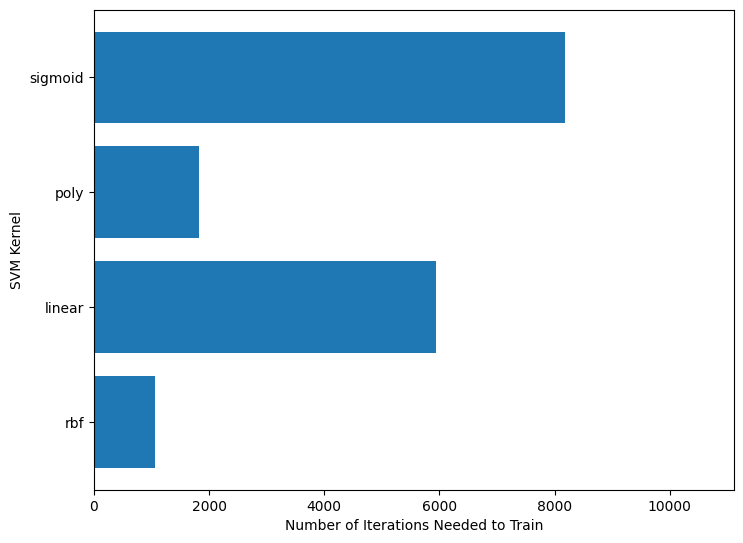

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
ax.barh(kernels,num_iter)

max_xlim = max(num_iter) + np.std(num_iter)
min_xlim = 0
plt.xlim(min_xlim, max_xlim)
plt.xlabel('Number of Iterations Needed to Train')
plt.ylabel('SVM Kernel')
plt.show()

In [41]:
# Generate test_times array
test_times = []
test_times.append(svm1_test_time)
test_times.append(svm2_test_time)
test_times.append(svm3_test_time)
test_times.append(svm4_test_time)

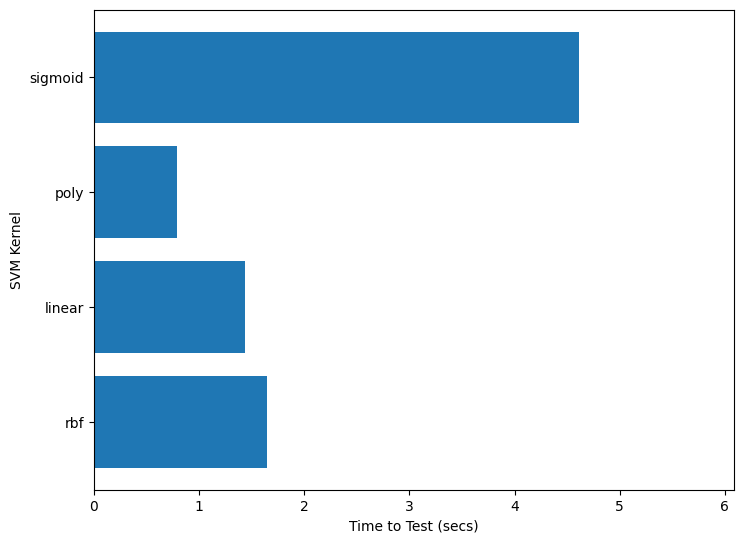

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
ax.barh(kernels,test_times)

max_xlim = max(test_times) + np.std(test_times)
min_xlim = 0
plt.xlim(min_xlim, max_xlim)
plt.xlabel('Time to Test (secs)')
plt.ylabel('SVM Kernel')
plt.show()

## Task 3: Select 2 Features. Train and test the Linear and RBF kernels against the 2 feature set, and visualize the decision bounary 

### Select Top 2 Features via Feature Selection

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

print("selecting best via chi2:")
selector = SelectKBest(chi2, k=2).fit(X_reduced, y1)
print(selector.get_feature_names_out())

selecting best via chi2:
['count' 'service_ecr_i']


### Find important features using LogisticRegression

In [44]:
# Train the LogisticRegression model with the training data.
# After trial and error, 300 is roughly the minimum number of iterations at which the training will converge.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, max_iter=5000)
print(lr.get_params())
lr.fit(X_train, y_train)
print(f"iterations required: {lr.n_iter_}")

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
iterations required: [113]


In [45]:
# Print number of each feature with its coeffiecient, in sorted order
numFeatures = lr.coef_[0].size
sorted_coef = np.empty(shape = (numFeatures,2), dtype=object)
for i in range(numFeatures):
    sorted_coef[i, 0] = i
    sorted_coef[i, 1] = lr.coef_[0][i]

sorted_coef = sorted_coef[sorted_coef[:,1].argsort()] 

print("Most positively correlated features:")    
for rank in range (14,-1,-1): 
    colnum, coef = sorted_coef[rank]
    print(f"{X_reduced.columns[colnum]} ({colnum}): {coef:6.2f}")    

Most positively correlated features:
srv_count (2):  16.38
service_ecr_i (12):  13.55
protocol_type_tcp (10):   5.14
serror_rate (3):   3.30
dst_host_srv_serror_rate (8):   1.40
dst_host_serror_rate (7):   1.01
protocol_type_icmp (9):   0.98
flag_S0 (14):   0.47
srv_serror_rate (4):  -1.71
count (1):  -2.55
srv_diff_host_rate (5):  -2.95
service_http (13):  -4.50
protocol_type_udp (11):  -6.12
logged_in (0):  -6.22
dst_host_same_src_port_rate (6): -14.23


In [46]:
X_reduced.describe()

,logged_in,count,srv_count,serror_rate,srv_serror_rate,srv_diff_host_rate,dst_host_same_src_port_rate,dst_host_serror_rate,dst_host_srv_serror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_ecr_i,service_http,flag_S0
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000
mean,0.346605,0.423639,0.371571,0.114498,0.114645,0.068604,0.437725,0.114797,0.114307,0.373480,0.532300,0.094220,0.362530,0.304870,0.11339
std,0.475890,0.452538,0.467767,0.316705,0.317761,0.213252,0.477475,0.316639,0.317523,0.483729,0.498957,0.292135,0.480732,0.460353,0.31707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.005871,0.005871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.201566,0.031311,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Train using 2 features

We decide to use "count" and "srv_count" for our features. "srv_count" has the largest absolute value coefficient from our LogisticRegression model, and "count" is picked as one of the two most important features by the SelectKBest class. More importantly, those columns have a more even data spread than most columns, and so gives us a more interesting data visualization.

In [47]:
# Pull out the feature set and result set from the data
print(f"shape of data set: {df.shape}")
print(X.columns)

# Include only count and srv_count in the new data set (X20)
#X20 = X.iloc[:, [23, 35]]
#X20 = X.iloc[:, [4, 5]]
X20 = X_reduced.iloc[:, [1, 2]] # count, srv_count

print(f"shape of X: {X20.shape}")
print(X20)

shape of data set: (4898430, 42)
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')
shape of X: (200000, 2)
           count  srv_count
0       0.001957   0.001957
1       0.003914   0.003914
2       0.023483 

In [48]:
# Reduce to only 50 positive and 50 negative records, to make visualization reasonable.
# Our new data set we call X21.
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y1))
rus = RandomUnderSampler(random_state=20, sampling_strategy={1:50, 0:50})
X21, y21 = rus.fit_resample(X20, y1)
print('Resampled dataset shape %s' % Counter(y21))
print(X21.shape)
X21.describe()

Original dataset shape Counter({0: 100000, 1: 100000})
Resampled dataset shape Counter({0: 50, 1: 50})
(100, 2)


,count,srv_count
count,100.000000,100.000000
mean,0.437358,0.412368
std,0.471867,0.482652
min,0.001957,0.001957
25%,0.003914,0.007339
50%,0.139922,0.033268
75%,1.000000,1.000000
max,1.000000,1.000000


In [49]:
# Our plotting mechanisms want ndarray, so convert from Dataframe to ndarray.
X22 = X21.values
y22 = y21

print(X22.shape)
print(y22.shape)

(100, 2)
(100,)


In [50]:
# Create arrays for plotting the data set
pos_feat1 = []
pos_feat2 = []
neg_feat1 = []
neg_feat2 = []

for i in range(y22.size):
    if y22[i] == 1:
        pos_feat1.append(X22[i][0])
        pos_feat2.append(X22[i][1])
    else:
        neg_feat1.append(X22[i][0])
        neg_feat2.append(X22[i][1])

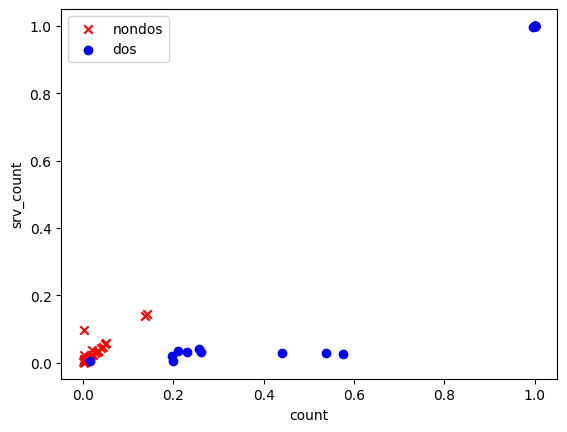

In [51]:
# Plot the data set, using Red X's for non-DOS and Blue Circles for DOS
%matplotlib inline
import matplotlib.pyplot as plt

# plot data
plt.scatter(neg_feat1, neg_feat2,
            color='red', marker='x', label='nondos')
plt.scatter(pos_feat1, pos_feat2,
            color='blue', marker='o', label='dos')

plt.xlabel(X21.columns[0])
plt.ylabel(X21.columns[1])
plt.legend(loc='upper left')

plt.show()

## Train against linear kernel

In [52]:
from sklearn.svm import SVC

svm5 = SVC(kernel='linear', random_state=0)
print(svm5.get_params())
svm5.fit(X22, y22)

print(f"iterations required: {svm5.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [13]


In [53]:
# Define the plot_decision_regions function, which is copied from Week 2 lab
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

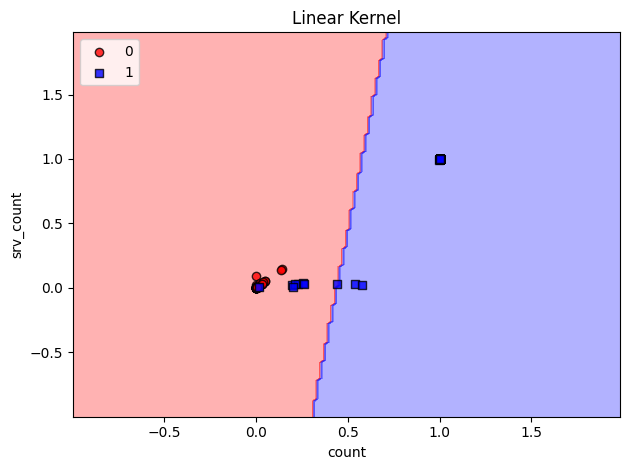

In [54]:
# Plot the decision region generated by the Linear SVM kernel
plot_decision_regions(X22, y22, classifier=svm5)
plt.title('Linear Kernel')
plt.xlabel(X21.columns[0])
plt.ylabel(X21.columns[1])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Train against RBF kernel

In [55]:
from sklearn.svm import SVC

svm6 = SVC(kernel='rbf', random_state=0)
print(svm6.get_params())
svm6.fit(X22, y22)

print(f"iterations required: {svm6.n_iter_}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
iterations required: [18]


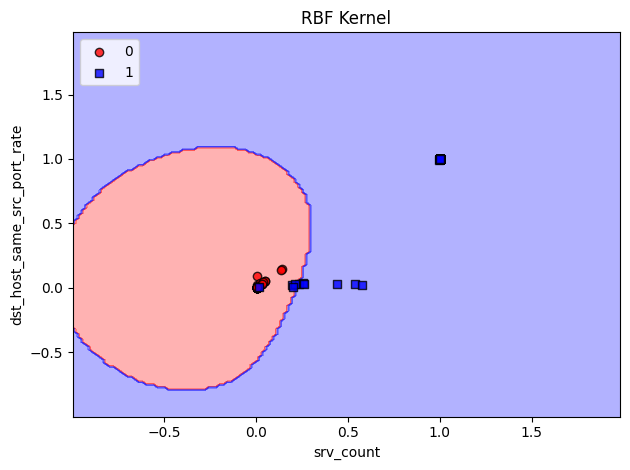

In [56]:
# Plot the decision region generated by the RBF SVM Kernel
plot_decision_regions(X22, y22, classifier=svm6)
plt.title('RBF Kernel')
plt.xlabel('srv_count')
plt.ylabel('dst_host_same_src_port_rate')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Discuss our observations

As indicated by the name, the linear kernel created a straight-line boundary for the decision regions. The decision boundary does not work very well for this very small, 2 feature data set. The RBF kernel, on the other hand, drew a shape for the decision boundary that looks like a slightly distorted circle. The boundary is very interesting and captures the data sets much better than the linear kernel did.